In [1]:
import numpy as np
from time import time
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from sklearn.feature_extraction.text import CountVectorizer
import torch
from tqdm.notebook import tqdm
# User functions
from utils import BaseTransport, GaussianTransport, get_trajectories_for_plotting, calc_parsimony, W2_dist

# We will be using data from  the UCI: Breast Cancer Wisconsin (Original)
experiment_name = 'CivilComments'
data_dir = Path('data')

In [2]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:
    figure_dir = Path('.') / 'figures' / experiment_name  # saves all figures in a figure directory in the local directory
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [3]:
entire_notebook_start_time = time()

## Loading in the data

In [4]:
# data hyperparameters
max_features = 500
# since we have *many features* now, we limit the max number of features features we search over
max_k_shift = 100

# Choose one of the comment sections below to uncomment, and then run the notebook with that uncommented
# to recreate that experiment!

# uncomment below for Explain('female' -> 'male')
# is_subdemographic = False
# training_frac = 0.2  # used to balance the sample numbers across experiments
# demo1 = 'female'
# demo2 = 'male'
#

# # uncomment below for Explain('F_0' -> 'F_1')
# is_subdemographic = True
# training_frac = 1  # used to balance the sample numbers across experiments
# demo_base = 'female'
##

# # uncomment below for Explain('M_0' -> 'M_1')
is_subdemographic = True
training_frac = 1  # used to balance the sample numbers across experiments
demo_base = 'male'
##

if is_subdemographic:
    demo1 = demo_base + '_nontoxic'  # nontoxic
    demo2 = demo_base + '_toxic'     # toxic

In [5]:
from wilds import get_dataset

In [6]:
dataset = get_dataset(dataset='civilcomments', unlabeled=False, root_dir=str(data_dir))

In [7]:
train = dataset.get_subset('train', frac=training_frac)
# train = dataset.get_subset('train')

In [8]:
demographics_data = {'male':[], 'female':[], 'lgbtq':[], 'christian':[], 'muslim':[],
                    'other religions':[], 'white':[], 'black':[]}
demographics_label = {'male':[], 'female':[], 'lgbtq':[], 'christian':[], 'muslim':[],
                      'other religions':[], 'white':[], 'black':[]}

In [9]:
# splitting the training data up into the demographic groups
all_data_arr = np.array(train, dtype=object)  # moving to np since indexing can be quirky in pytorch
for metadata_col, corresponding_key in enumerate(demographics_data):
    rows_in_demographic = train.metadata_array[:, metadata_col] == 1
    demographics_data[corresponding_key] = all_data_arr[rows_in_demographic][:, 0]
    demographics_label[corresponding_key] = np.array([item.item() for item in all_data_arr[rows_in_demographic][:, 1]])

In [10]:
if is_subdemographic:
    # adding base_nontoxic and base_toxic to the demographics data and labels
    demographics_data[demo1] = demographics_data[demo_base][demographics_label[demo_base] == 0]
    demographics_label[demo1] = demographics_label[demo_base][demographics_label[demo_base] == 0]

    demographics_data[demo2] = demographics_data[demo_base][demographics_label[demo_base] == 1]
    demographics_label[demo2] = demographics_label[demo_base][demographics_label[demo_base] == 1]

In [11]:
def get_demographic_counts(demo1, demo2, demographics_data,
                           ngram, max_features, equalize_sizes=False):
    # splitting between demographic attribute 1 and 2
    og_X0 = demographics_data[demo1]
    og_X1 = demographics_data[demo2]
    if equalize_sizes:
        print('Equalizing sizes.')
        print('OG sizes:', (og_X0.shape, og_X1.shape))
        if og_X0.shape[0] < og_X1.shape[0]:
            rng = np.random.RandomState(42)
            subsample_idxs = rng.choice(len(og_X1), replace=False, size=len(og_X0))
            og_X1 = og_X1[subsample_idxs]  # subsampling to equalize sizes
        elif og_X0.shape[0] > og_X1.shape[0]:
            rng = np.random.RandomState(42)
            subsample_idxs = rng.choice(len(og_X0), replace=False, size=len(og_X1))
            og_X0 = og_X0[subsample_idxs]
        print('New sizes:', (og_X0.shape, og_X1.shape))
    og_X_both = np.concatenate((og_X0, og_X1))
    ngram_vectorizer = CountVectorizer(ngram_range=(ngram,ngram),
                                       stop_words='english', max_features=max_features)
    vectorized_data = ngram_vectorizer.fit_transform(og_X_both)
    X0, X1 = vectorized_data[:og_X0.shape[0]], vectorized_data[og_X0.shape[0]:] 
    return X0.toarray().astype(float), X1.toarray().astype(float), ngram_vectorizer

In [12]:
ngram = 1  # used for setting the ngram range when building the ngram bag of words




X0, X1, ngram_vectorizer = get_demographic_counts(demo1, demo2, demographics_data,
                                                  ngram, max_features, equalize_sizes=True)
print(X0.shape, X1.shape)

Equalizing sizes.
OG sizes: ((25373,), (4437,))
New sizes: ((4437,), (4437,))
(4437, 500) (4437, 500)


In [13]:
def plot_shift(environment0, environment1, environment2=None, environment_labels=None, features='all', **fig_kwargs):
    if environment2 is None:
        environments = [environment0, environment1]
    else:
        environments = [environment0, environment1, environment2]
        
    fig, axes = plt.subplots(len(environments), 1, **fig_kwargs)
    for environment_idx, environment in enumerate(environments):
        if type(features) == str and features == 'all':
            features = np.arange(environment.shape[1])
        for feature_idx in features:
            axes[environment_idx].plot(environment[:, feature_idx])
        if environment_labels:
            axes[environment_idx].set_title(f'Environment {environment_labels[environment_idx]}')
        else:
            axes[environment_idx].set_title(f'Environment {environment_idx}')
    plt.tight_layout()
    return None

In [14]:
def plot_shift_results(W2s, W2_deltas, transport_costs):
    fig, axes = plt.subplots(3,1, figsize=(8, 8), sharex='all')
    fontsize=10
    axes[0].plot(W2s, **line_parms)
    axes[0].set_title(r'$W_2^2 (T^{(\ell)}(X), Y)$ distance')
    # axes[1].plot(np.diff(W2_deltas))
    axes[1].plot(W2_deltas, **line_parms)
    axes[1].set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)')
    # axes[1].set_title('Percent of change explained')
    axes[2].plot(transport_costs, **line_parms)
    axes[2].set_title('Transport Cost')
    axes[2].set_xlabel('Number of features altered')
    plt.tight_layout()
    plt.show()

### Optimal Transport Between Enviroments

In [15]:
T = BaseTransport(X0, X1, fit=False, max_iter=1e9)

In [16]:
d_X01 = W2_dist(X0, X1)
Z01 = T.fit_transform(X0, X1, 'forward')
d_Z01 = W2_dist(Z01, X1)

In [17]:
print(f'W2(E0, E1)={d_X01:.3f},\t W2(T_ot(E0), E1)={d_Z01:.3f}')

W2(E0, E1)=26.822,	 W2(T_ot(E0), E1)=0.000


### Sparse Mean shift transport
Here are performing mean shift transport between E0, E1 

In [18]:
def iterative_mean_shift_transport(X, Y, log=False, max_k_shift=None,
                                   feature_names=None):
    if log:
        from time import time
        start_time = time()
    W2_X_Y = W2_dist(X, Y)  # calculating the W2 distance before any transporting
    X_means = X.mean(axis=0)
    Y_means = Y.mean(axis=0)
    mean_diff_sort = np.argsort(abs(X_means - Y_means))[::-1]  # sorts in decreasing order
    free_dim_mask = np.zeros(X.shape[1], dtype=bool)  # a mask where True mean that feature can be transported
    Z_constrained = X.copy()
    
    if max_k_shift is None:
        max_k_shift = X.shape[1]
    

    W2s = np.zeros(max_k_shift+1)  # W_2^2 distances of each transport, including T=id
    W2s[0] = W2_X_Y
    W2_deltas = np.zeros(max_k_shift)
    transport_costs = np.zeros(max_k_shift+1)
    free_dims_over_time = [[]]
    shift_directions = []
    
    for n_free in tqdm(range(max_k_shift)):
        newest_free = mean_diff_sort[n_free]  # selecting the next feature to be included in the transport
        free_dim_mask[newest_free] = True
        Z_constrained[:, newest_free] += Y_means[newest_free] - X_means[newest_free]
        shift_direction = np.sign(Y_means[newest_free] - X_means[newest_free])
        d_Z_Y = W2_dist(Y, Z_constrained)
        # recording
        shift_directions.append(shift_direction)
        percent_change = 100*(W2_X_Y - d_Z_Y) / W2_X_Y  # given as a %
        W2_deltas[n_free] = percent_change
        W2s[n_free] = d_Z_Y
        transport_costs[n_free+1] = calc_parsimony(X, Z_constrained)
        free_dims_over_time.append(np.flatnonzero(free_dim_mask))
        shifted_by = Y_means[free_dims_over_time[-1]] - X_means[free_dims_over_time[-1]]
        indicies_to_reverse_sort = shifted_by.argsort()[::-1]   # [::-1] to sort in decreasing order
        with np.printoptions(precision=2, suppress=True):
#             if feature_names is None:
#                 shifted_names = free_dims_over_time[-1][indicies_to_reverse_sort]
#             else:
#                 shifted_names = feature_names[free_dims_over_time[-1][indicies_to_reverse_sort]]
#             print(f'For {n_free} free features:\n',
#                   f'\tFeatures: {shifted_names} have been shifted by: {shifted_by[indicies_to_reverse_sort]}\n', 
#                   f'\tW2: {d_Z_Y:.3f},\tTotal shift explained: {percent_change:.1f}%')
            print(f'For {n_free+1} free,\tW2: {d_Z_Y:.3f},\tTotal shift explained: {percent_change:.3f}%')
    if log:
        print(f'\nTook {(time() - start_time)/60:.3} mins')
    return W2s, W2_deltas, transport_costs, free_dims_over_time, shift_directions

In [19]:
W2s, W2_deltas, transport_costs, free_dims_over_time, directions = iterative_mean_shift_transport(X0, X1, log=True,
                                                                                      max_k_shift=max_k_shift,
                                                                                      feature_names=ngram_vectorizer.get_feature_names_out())
E01_sparse_mean_shift_results = [W2s, W2_deltas, transport_costs, free_dims_over_time, directions]

  0%|          | 0/100 [00:00<?, ?it/s]

For 1 free,	W2: 26.778,	Total shift explained: 0.163%
For 2 free,	W2: 26.761,	Total shift explained: 0.227%
For 3 free,	W2: 26.749,	Total shift explained: 0.272%
For 4 free,	W2: 26.738,	Total shift explained: 0.312%
For 5 free,	W2: 26.733,	Total shift explained: 0.332%
For 6 free,	W2: 26.728,	Total shift explained: 0.349%
For 7 free,	W2: 26.725,	Total shift explained: 0.363%
For 8 free,	W2: 26.722,	Total shift explained: 0.373%
For 9 free,	W2: 26.720,	Total shift explained: 0.381%
For 10 free,	W2: 26.718,	Total shift explained: 0.389%
For 11 free,	W2: 26.716,	Total shift explained: 0.396%
For 12 free,	W2: 26.714,	Total shift explained: 0.403%
For 13 free,	W2: 26.713,	Total shift explained: 0.408%
For 14 free,	W2: 26.711,	Total shift explained: 0.413%
For 15 free,	W2: 26.710,	Total shift explained: 0.417%
For 16 free,	W2: 26.709,	Total shift explained: 0.421%
For 17 free,	W2: 26.708,	Total shift explained: 0.425%
For 18 free,	W2: 26.707,	Total shift explained: 0.428%
For 19 free,	W2: 26

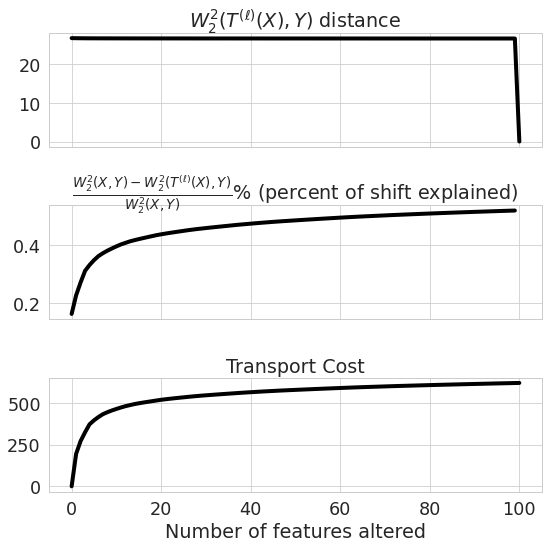

In [20]:
# Plotting results for sparse mean shift transport between E0, E1
plot_shift_results(W2s, W2_deltas, transport_costs)

#### Iterative unconstrained feature transport

In [21]:
def iterative_unconstrained_feature_transport(X, Y, T, log=False, max_k_shift=None,
                                              feature_names=None):
    if max_k_shift is None:
        max_k_shift = X.shape[1]
    if log:
        from time import time
        start_time = time()
        print('Calculating Zot')
    Z_OT = T.fit(X,Y).forward(X)
    if log:
        print('Zot calculated!')
    W2_X_Y = W2_dist(X, Y)  # calculating the W2 distance before any transporting
    argsorted_diff = np.linalg.norm(Z_OT - X, axis=0).argsort()[::-1]  # a feature-wise divergence array in decreasing order
    free_dim_mask = np.zeros(X.shape[1], dtype=bool)  # a mask where True mean that feature can be transported
    Z_sparse_OT = X.copy()
    W2s = np.zeros(max_k_shift+1)  # W_2^2 distances of each transport, including T=id
    W2s[0] = W2_X_Y
    W2_deltas = np.zeros(max_k_shift)
    transport_costs = np.zeros(max_k_shift+1)
    free_dims_over_time = [[]]
    shift_directions = []
    for n_free in tqdm(range(max_k_shift)):
        newest_free = argsorted_diff[n_free]  # selecting the next feature to be included in the transport
        free_dim_mask[newest_free] = True
        Z_sparse_OT[:, newest_free] = Z_OT[:, newest_free]
        shift_direction = np.sign((Z_OT[:, newest_free] - X[:, newest_free]).mean())
        d_Z_Y = W2_dist(Y, Z_sparse_OT)
        # recording
        percent_change = 100*(W2_X_Y - d_Z_Y) / W2_X_Y  # given as a %
        W2_deltas[n_free] = percent_change
        W2s[n_free+1] = d_Z_Y
        transport_costs[n_free+1] = calc_parsimony(X, Z_sparse_OT)
        free_dims_over_time.append(np.flatnonzero(free_dim_mask))
        shift_directions.append(shift_direction)
        print(f'For {n_free+1} free,\tW2: {d_Z_Y:.3f},\tTotal shift explained: {percent_change:.3f}%')
    if log:
        print(f'\nTook {(time() - start_time)/60:.3} mins')
    return W2s, W2_deltas, transport_costs, free_dims_over_time, shift_directions

In [22]:
T = BaseTransport(X0, X1, fit=False, max_iter=1e9)
W2s, W2_deltas, transport_costs, free_dims_over_time, directions = iterative_unconstrained_feature_transport(X0, X1, T,
                                                                                                 log=True,
                                                                                                 max_k_shift=max_k_shift)
E01_unconstrained_sparse_shift_results = [W2s, W2_deltas, transport_costs, free_dims_over_time, directions]

Calculating Zot
Zot calculated!


  0%|          | 0/100 [00:00<?, ?it/s]

For 1 free,	W2: 26.419,	Total shift explained: 1.502%
For 2 free,	W2: 26.071,	Total shift explained: 2.801%
For 3 free,	W2: 25.733,	Total shift explained: 4.059%
For 4 free,	W2: 25.404,	Total shift explained: 5.288%
For 5 free,	W2: 25.121,	Total shift explained: 6.341%
For 6 free,	W2: 24.858,	Total shift explained: 7.320%
For 7 free,	W2: 24.605,	Total shift explained: 8.267%
For 8 free,	W2: 24.358,	Total shift explained: 9.188%
For 9 free,	W2: 24.122,	Total shift explained: 10.067%
For 10 free,	W2: 23.902,	Total shift explained: 10.886%
For 11 free,	W2: 23.709,	Total shift explained: 11.605%
For 12 free,	W2: 23.517,	Total shift explained: 12.322%
For 13 free,	W2: 23.341,	Total shift explained: 12.977%
For 14 free,	W2: 23.170,	Total shift explained: 13.615%
For 15 free,	W2: 23.004,	Total shift explained: 14.234%
For 16 free,	W2: 22.840,	Total shift explained: 14.844%
For 17 free,	W2: 22.684,	Total shift explained: 15.426%
For 18 free,	W2: 22.534,	Total shift explained: 15.987%
For 19 fr

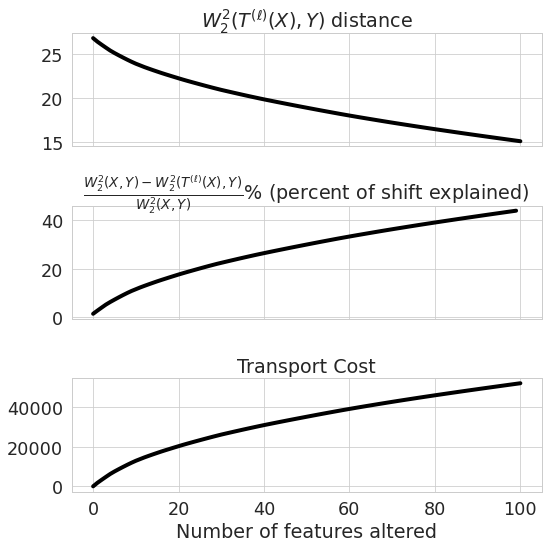

In [23]:
# Plotting results for unconstrained sparse shift transport between E0, E1
plot_shift_results(W2s, W2_deltas, transport_costs)

## Generating plots specifically to be shown in paper

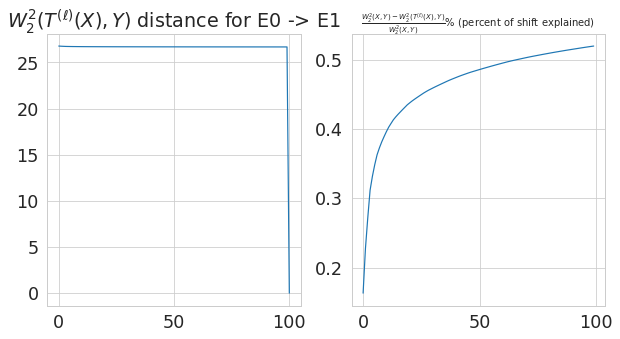

In [24]:
# Visualizing the Pareoto Frontier and % explained for E0->E1 for sparse mean shift
fontsize=10
figs, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(E01_sparse_mean_shift_results[0])
axes[0].set_title(r'$W_2^2 (T^{(\ell)}(X), Y)$ distance for E0 -> E1')
axes[1].plot(E01_sparse_mean_shift_results[1])
axes[1].set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)', fontsize=fontsize)
plt.show()

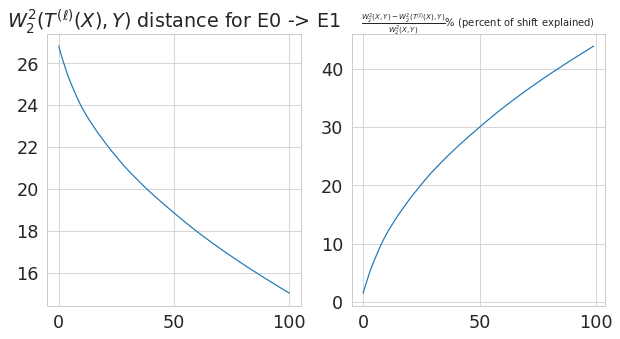

In [25]:
# Visualizing the % explained for both E0->E1 and E1->E2 for unconstrained sparse feature shift
fontsize=10
figs, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(E01_unconstrained_sparse_shift_results[0])
axes[0].set_title(r'$W_2^2 (T^{(\ell)}(X), Y)$ distance for E0 -> E1')
axes[1].plot(E01_unconstrained_sparse_shift_results[1])
axes[1].set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)', fontsize=fontsize)
plt.show()

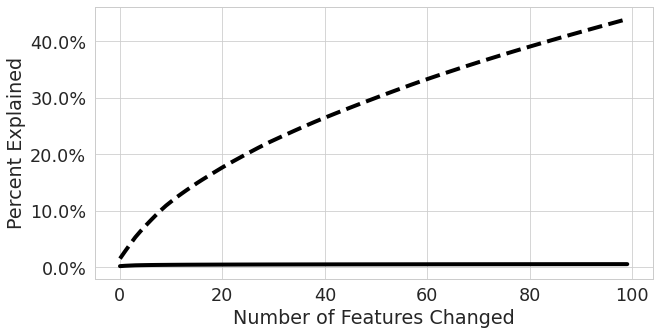

In [26]:
# Visualizing the Pareoto Frontier and % explained for both E0->E1 and E1->E2 for sparse mean shift
fontsize=15
figs, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(E01_sparse_mean_shift_results[1], **line_parms)
axes.plot(E01_unconstrained_sparse_shift_results[1], **line_parms, linestyle='--')
if add_title: axes.set_title(r'$\frac{W_2^2 (X, Y) - W_2^2 (T^{(\ell)}(X), Y)}{W_2^2 (X, Y)}$% (percent of shift explained)', fontsize=fontsize)
for idx in range(1):
    axes.set_xlabel('Number of Features Changed')
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.tight_layout()
# plt.legend()
axes.set_ylabel('Percent Explained')
if add_legend: plt.legend()
if save_figures: plt.savefig(figure_dir / f'mean-shift-E01-E12-percent-explained.{save_parms["format"]}', **save_parms)
plt.show()

In [27]:
print(f'The Full notebook took {(time() - entire_notebook_start_time)/60:.3} mins')

The Full notebook took 20.7 mins


In [28]:
def sign_to_str(sign):
    if sign == 1 or sign == 1.0:
        return '+'
    else:
        return '-'

In [29]:
def convert_free_dims(free_dims_over_time):
    # converting free_dims_over_time to an array where the jth element
    # is the dim that is added at the jth timestep
    free_dims = []
    for free_dims_at_t in free_dims_over_time:
        for free_dim in free_dims_at_t:
            if free_dim not in free_dims:
                free_dims.append(free_dim)
    free_dims = np.array(free_dims)
    return free_dims

mean_free_dims = convert_free_dims(E01_sparse_mean_shift_results[-2])
OT_free_dims = convert_free_dims(E01_unconstrained_sparse_shift_results[-2])

feature_names = ngram_vectorizer.get_feature_names_out()
previous_OT_W2_delta = 0.0
previous_mean_W2_delta = 0.0

mean_words = []
OT_words = []

print(f'For pushforward of {demo1} comments to {demo2} comments:')

for idx in range(1,max_k_shift):
    mean_free_dim = mean_free_dims[idx]
    curr_mean_W2_delta = E01_sparse_mean_shift_results[1][idx]
    
    OT_free_dim = OT_free_dims[idx]
    curr_OT_W2_delta = E01_unconstrained_sparse_shift_results[1][idx]
    
    mean_words.append(feature_names[mean_free_dim])
    OT_words.append(feature_names[OT_free_dim])
    
    OT_dir = sign_to_str(E01_unconstrained_sparse_shift_results[-1][idx])
    mean_dir = sign_to_str(E01_sparse_mean_shift_results[-1][idx])
    
    message = f'For k={idx}:\n\tmean:\t{mean_dir} {feature_names[mean_free_dim]}\t{curr_mean_W2_delta:.4}%\n' + \
              f'\tOT:\t{OT_dir} {feature_names[OT_free_dim]}\t{curr_OT_W2_delta:.4}%\n'
    print(message)
    
    previous_mean_W2_delta = curr_mean_W2_delta
    previous_OT_W2_delta = curr_OT_W2_delta

For pushforward of male_nontoxic comments to male_toxic comments:
For k=1:
	mean:	+ trump	0.2272%
	OT:	- women	2.801%

For k=2:
	mean:	- women	0.2716%
	OT:	- men	4.059%

For k=3:
	mean:	+ black	0.3117%
	OT:	+ man	5.288%

For k=4:
	mean:	- church	0.3318%
	OT:	+ people	6.341%

For k=5:
	mean:	+ stupid	0.3485%
	OT:	+ like	7.32%

For k=6:
	mean:	+ gay	0.3627%
	OT:	+ trump	8.267%

For k=7:
	mean:	+ racist	0.3727%
	OT:	+ just	9.188%

For k=8:
	mean:	- god	0.3813%
	OT:	+ don	10.07%

For k=9:
	mean:	- jesus	0.3889%
	OT:	+ black	10.89%

For k=10:
	mean:	+ man	0.3961%
	OT:	- male	11.61%

For k=11:
	mean:	+ sex	0.4027%
	OT:	- woman	12.32%

For k=12:
	mean:	- female	0.408%
	OT:	- know	12.98%

For k=13:
	mean:	+ like	0.4132%
	OT:	- think	13.61%

For k=14:
	mean:	- time	0.4173%
	OT:	- time	14.23%

For k=15:
	mean:	+ rape	0.4211%
	OT:	- church	14.84%

For k=16:
	mean:	- good	0.4246%
	OT:	- right	15.43%

For k=17:
	mean:	+ muslim	0.4281%
	OT:	- did	15.99%

For k=18:
	mean:	- did	0.4315%
	OT:	+ want	16